<a href="https://colab.research.google.com/github/lucywowen/CDL-bibliography/blob/master/neural_network_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks

> We're going to use the [this](https://www.kaggle.com/datasets/jamesleslie/titanic-cleaned-data) Titanic dataset for an introduction to neural networks.  

> This notebook was modified from [this](https://www.kaggle.com/code/jamesleslie/titanic-neural-network-for-beginners) Kaggle notebook.

> We'll be using this notebook and covering all of the steps required to train, tune and assess a neural network using Keras.

 # Load packages and data

## Load the libraries

In [7]:
# !pip install scikeras
# !pip install keras

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 10,8
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (15,10)})
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

from numpy.random import seed
import tensorflow
tensorflow.random.set_seed(42)


In [13]:
from google.colab import files
uploaded = files.upload()

Saving test_clean.csv to test_clean.csv
Saving train_clean.csv to train_clean.csv


## Load data

In [14]:
# Load data as Pandas dataframe
train = pd.read_csv('train_clean.csv', )
test = pd.read_csv('test_clean.csv')
df = pd.concat([train, test], axis=0, sort=True)


Look at the dataframe

In [16]:
df.head()

,Age,Cabin,Embarked,Family_Size,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,NaN,S,1,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr
1,38.0,C85,C,1,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs
2,26.0,NaN,S,0,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss
3,35.0,C123,S,1,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs
4,35.0,NaN,S,0,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr


This is a kinda nice was to display a dataframe!

In [15]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000):
        display(df)


display_all(df.describe(include='all').T)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,1309.0,NaN,NaN,NaN,29.562391,13.16536,0.17,22.0,30.0,35.5,80.0
Cabin,295,186,C23 C25 C27,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Embarked,1309,3,S,915,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Family_Size,1309.0,NaN,NaN,NaN,0.883881,1.583639,0.0,0.0,0.0,1.0,10.0
Fare,1309.0,NaN,NaN,NaN,33.276193,51.743584,0.0,7.8958,14.4542,31.275,512.3292
Name,1309,1307,"Connolly, Miss. Kate",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Parch,1309.0,NaN,NaN,NaN,0.385027,0.86556,0.0,0.0,0.0,0.0,9.0
PassengerId,1309.0,NaN,NaN,NaN,655.0,378.020061,1.0,328.0,655.0,982.0,1309.0
Pclass,1309.0,NaN,NaN,NaN,2.294882,0.837836,1.0,2.0,3.0,3.0,3.0
Sex,1309,2,male,843,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Pre-processing

###  Encode Categorical Variables¶
> We need to convert all categorical variables into numeric format. The categorical variables we will be keeping are Embarked, Sex and Title.

> The Sex variable can be encoded into single 1-or-0 column, but the other variables will need to be one-hot encoded. Regular label encoding assigns some category labels higher numerical values. This implies some sort of scale (Embarked = 1 is not more than Embarked = 0 - it's just different). One Hot Encoding avoids this problem.

> We will assume that there is some ordinality in the `Pclass` variable, so we will leave that as a single column.

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


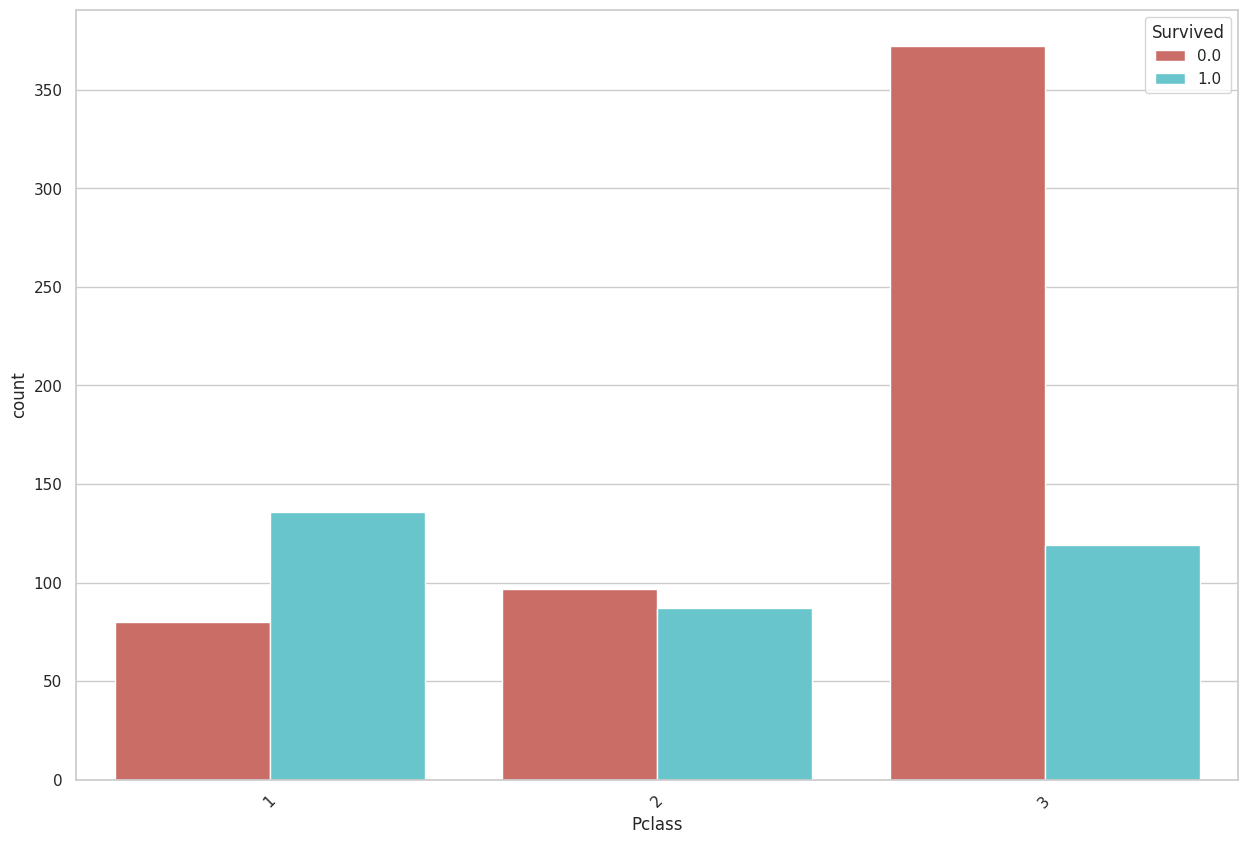

In [17]:
sns.countplot(x='Pclass', data=df, palette='hls', hue='Survived')
plt.xticks(rotation=45)
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


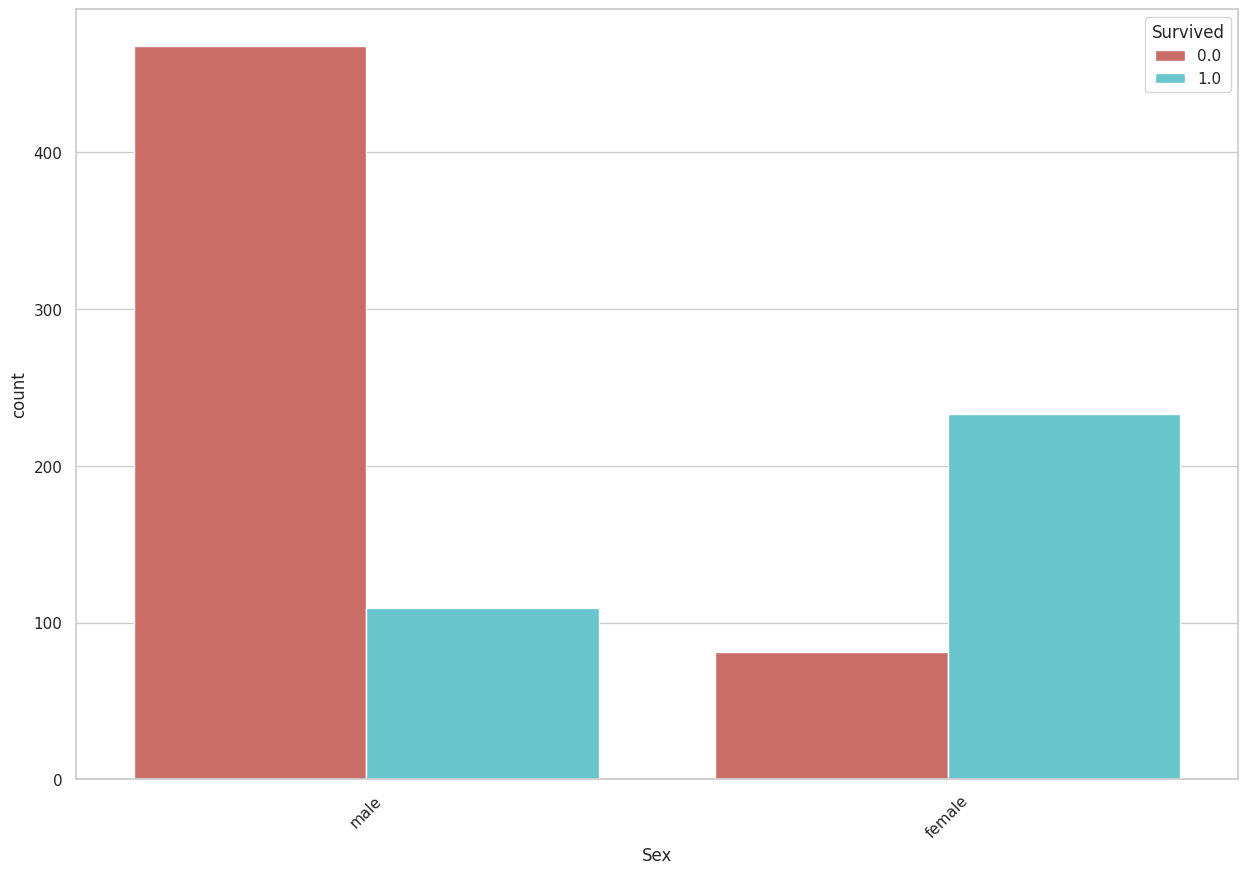

In [18]:
sns.countplot(x='Sex', data=df, palette='hls', hue='Survived')
plt.xticks(rotation=45)
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


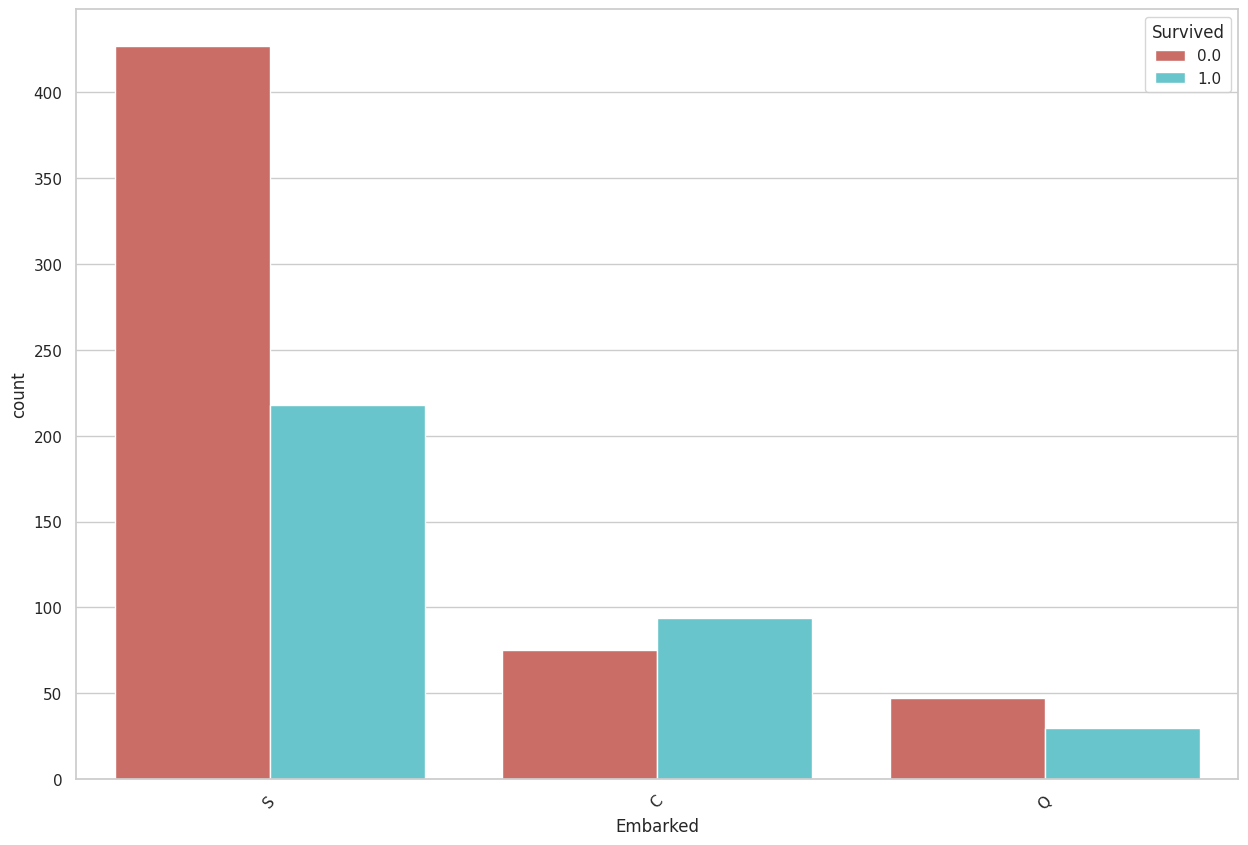

In [19]:
sns.countplot(x='Embarked', data=df, palette='hls', hue='Survived')
plt.xticks(rotation=45)
plt.show()

In [20]:
# convert to cateogry dtype
df['Sex'] = df['Sex'].astype('category')
# convert to category codes
df['Sex'] = df['Sex'].cat.codes

In [21]:
# subset all categorical variables which need to be encoded
categorical = ['Embarked', 'Title']

for var in categorical:
    df = pd.concat([df,
                    pd.get_dummies(df[var], prefix=var)], axis=1)
    del df[var]

In [22]:
# drop the variables we won't be using
df.drop(['Cabin', 'Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)

In [23]:
df.head()

,Age,Family_Size,Fare,Parch,Pclass,Sex,SibSp,Survived,Embarked_C,Embarked_Q,Embarked_S,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev
0,22.0,1,7.2500,0,3,1,1,0.0,False,False,True,False,False,False,True,False,False
1,38.0,1,71.2833,0,1,0,1,1.0,True,False,False,False,False,False,False,True,False
2,26.0,0,7.9250,0,3,0,0,1.0,False,False,True,False,False,True,False,False,False
3,35.0,1,53.1000,0,1,0,1,1.0,False,False,True,False,False,False,False,True,False
4,35.0,0,8.0500,0,3,1,0,0.0,False,False,True,False,False,False,True,False,False


### Scale Continuous Variables
The continuous variables need to be scaled. This is done using a standard scaler from `SkLearn`.

In [24]:
continuous = ['Age', 'Fare', 'Parch', 'Pclass', 'SibSp', 'Family_Size']

scaler = StandardScaler()

for var in continuous:
    df[var] = df[var].astype('float64')
    df[var] = scaler.fit_transform(df[var].values.reshape(-1, 1))

In [25]:
display_all(df.describe(include='all').T)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,1309.0,NaN,NaN,NaN,0.0,1.000382,-2.233408,-0.574635,0.033252,0.451175,3.832549
Family_Size,1309.0,NaN,NaN,NaN,0.0,1.000382,-0.558346,-0.558346,-0.558346,0.073352,5.758637
Fare,1309.0,NaN,NaN,NaN,0.0,1.000382,-0.643344,-0.490691,-0.363894,-0.03869,9.261749
Parch,1309.0,NaN,NaN,NaN,0.0,1.000382,-0.445,-0.445,-0.445,-0.445,9.956864
Pclass,1309.0,NaN,NaN,NaN,-0.0,1.000382,-1.546098,-0.352091,0.841916,0.841916,0.841916
Sex,1309.0,NaN,NaN,NaN,0.644003,0.478997,0.0,0.0,1.0,1.0,1.0
SibSp,1309.0,NaN,NaN,NaN,-0.0,1.000382,-0.479087,-0.479087,-0.479087,0.481288,7.203909
Survived,891.0,NaN,NaN,NaN,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
Embarked_C,1309,2,False,1038,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Embarked_Q,1309,2,False,1186,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Neural Network
Now, all that is left is to feed our data that has been cleaned, encoded and scaled to our neural network.

But first, we need to separate data_df back into train and test sets.

In [26]:
X_train = df[pd.notnull(df['Survived'])].drop(['Survived'], axis=1)
y_train = df[pd.notnull(df['Survived'])]['Survived']
X_test = df[pd.isnull(df['Survived'])].drop(['Survived'], axis=1)

## Cross-validation
Keras allows us to make use of cross-validation for training our model. So we will use this to train and assess our first model.

### Create neural network mode
> For this task, I have kept the model architecture pretty simple. We have one input layer with 17 nodes which feeds into a hidden layer with 8 nodes and an output layer which is used to predict a passenger's survival.

> The output layer has a sigmoid activation function, which is used to 'squash' all our outputs to be between 0 and 1.

> We are going to create a function which allows to parameterise the choice of hyperparameters in the neural network. This might seem a little overly complicated now, but it will come in super handy when we move onto tuning our parameters later.

In [27]:
def create_model(lyrs=[8], act='linear', opt='Adam', dr=0.0):

    # set random seed for reproducibility
    seed(42)

    model = Sequential()

    # create first hidden layer
    model.add(Dense(lyrs[0], input_dim=X_train.shape[1], activation=act))

    # create additional hidden layers
    for i in range(1,len(lyrs)):
        model.add(Dense(lyrs[i], activation=act))

    # add dropout, default is none
    model.add(Dropout(dr))

    # create output layer
    model.add(Dense(1, activation='sigmoid'))  # output layer

    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    return model

In [29]:
model = create_model()
print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 145 (580.00 B)

 Trainable params: 145 (580.00 B)

 Non-trainable params: 0 (0.00 B)

None


### Train model
> At this stage, we have our model. We have chosen a few hyperparameters such as the number of hidden layers, the number of neurons and the activation function.

> The next step is to train the model on our training set. This step also requires us to choose a few more hyperparameters such as the loss function, the optimization algorithm, the number of epochs and the batch size.

In [33]:
# train model on full train set, with 80/20 CV split
training = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)
val_acc = np.mean(training.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_accuracy', val_acc*100))


val_accuracy: 88.27%


Ok now lets assess the results

In [37]:
training.history

{'accuracy': [0.8188202381134033,
  0.8188202381134033,
  0.8188202381134033,
  0.8188202381134033,
  0.8188202381134033,
  0.8188202381134033,
  0.8188202381134033,
  0.8188202381134033,
  0.8188202381134033,
  0.8188202381134033,
  0.8188202381134033,
  0.8188202381134033,
  0.8188202381134033,
  0.8188202381134033,
  0.8188202381134033,
  0.8188202381134033,
  0.8188202381134033,
  0.8188202381134033,
  0.8188202381134033,
  0.8188202381134033,
  0.8188202381134033,
  0.8188202381134033,
  0.8188202381134033,
  0.8188202381134033,
  0.8188202381134033,
  0.8188202381134033,
  0.8188202381134033,
  0.8188202381134033,
  0.8188202381134033,
  0.8188202381134033,
  0.817415714263916,
  0.817415714263916,
  0.817415714263916,
  0.817415714263916,
  0.817415714263916,
  0.817415714263916,
  0.817415714263916,
  0.817415714263916,
  0.817415714263916,
  0.817415714263916,
  0.817415714263916,
  0.817415714263916,
  0.817415714263916,
  0.817415714263916,
  0.817415714263916,
  0.817415714

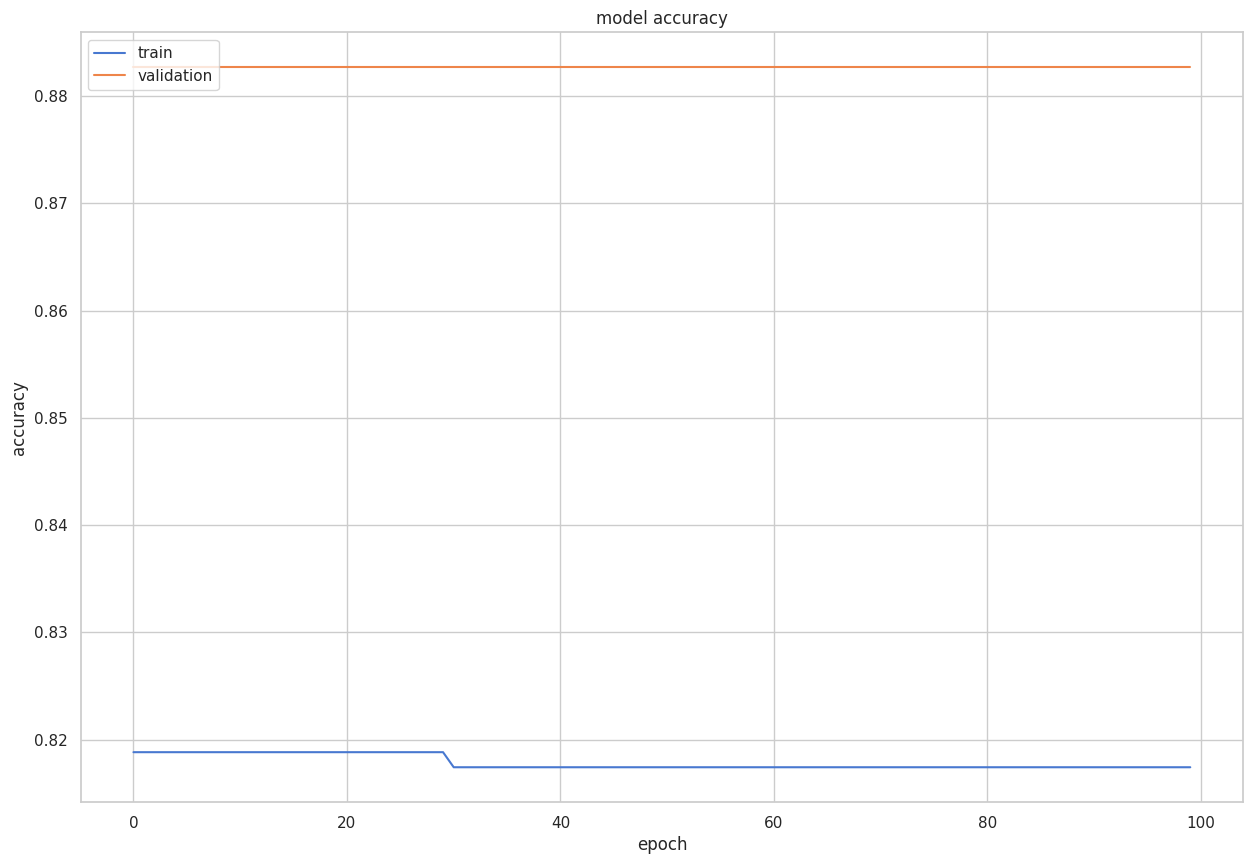

In [35]:
# summarize history for accuracy
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()